In [10]:
import sys, os

import soundfile as sf
import librosa
import numpy as np
import pandas as pd
import IPython.display as ipd
import sklearn

import matplotlib.pyplot as plt

In [2]:
def display_audio(t, sr):
    return ipd.Audio(t, rate=sr)

In [3]:
file_dir = '../victor experimental phonemes/'
files = [os.path.join(file_dir, f) for f in os.listdir(file_dir) if '.aif' in f or '.wav' in f]

In [513]:
# load audio
# audio, samplerate = sf.read('../audio/stereo_shuffled_jabberwocky.wav')
audio, samplerate = sf.read(files[0])
audio = audio#[:22050]
nsamps, nchans = audio.shape
nsamps, nchans, samplerate

(47261, 2, 44100)

In [514]:
audio = audio.mean(-1)
display(audio.shape)

(47261,)

In [520]:
display_audio(audio)

In [27]:
# extract features

In [544]:
# def window(arr, ws = 22050//5):
#     arr = np.ascontiguousarray(arr)
#     return np.lib.stride_tricks.as_strided(arr, (len(arr)-ws+1, ws), arr.strides*2)
def window(arr, ws = samplerate//2):
    arr = np.ascontiguousarray(arr)
    return np.lib.stride_tricks.as_strided(arr, arr.shape[:-1]+(arr.shape[-1]-ws+1, ws), arr.strides+(arr.strides[-1],))

In [545]:
def zero_xings(arr):
    return np.concatenate((np.zeros((1,)), arr[1:]*arr[:-1] < 0))

In [546]:
amp = window(abs(audio)).mean(-1)
amp -= amp.min()
amp /= amp.std()
amp.shape

(25212,)

In [547]:
std = window(audio).std(-1)/window(abs(audio)).mean(-1)
std -= std.min()
std /= std.std()
std.shape

(25212,)

In [548]:
zx = window(zero_xings(audio)).mean(-1)
zx -= zx.min()
zx /= zx.std()
zx.shape

(25212,)

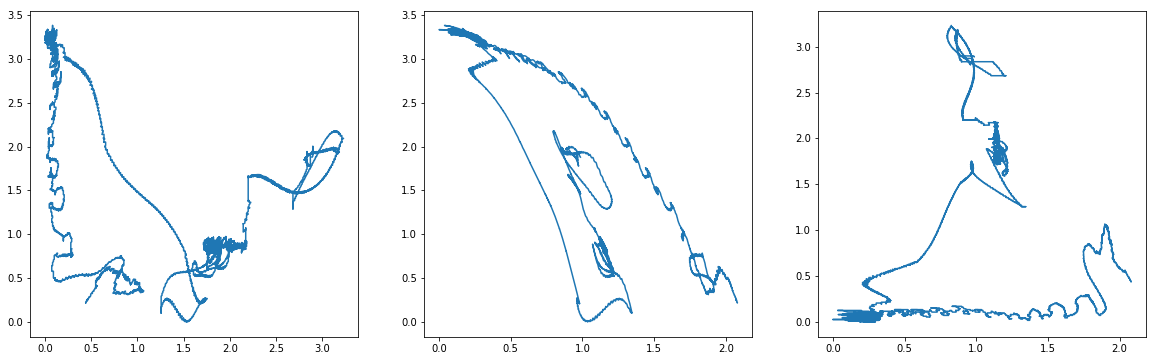

In [549]:
# plot
fig, ax = plt.subplots(1,3,figsize=(20, 6))
ax[0].plot(zx, std)
ax[1].plot(amp**.5, std)
ax[2].plot(amp**.5, zx)

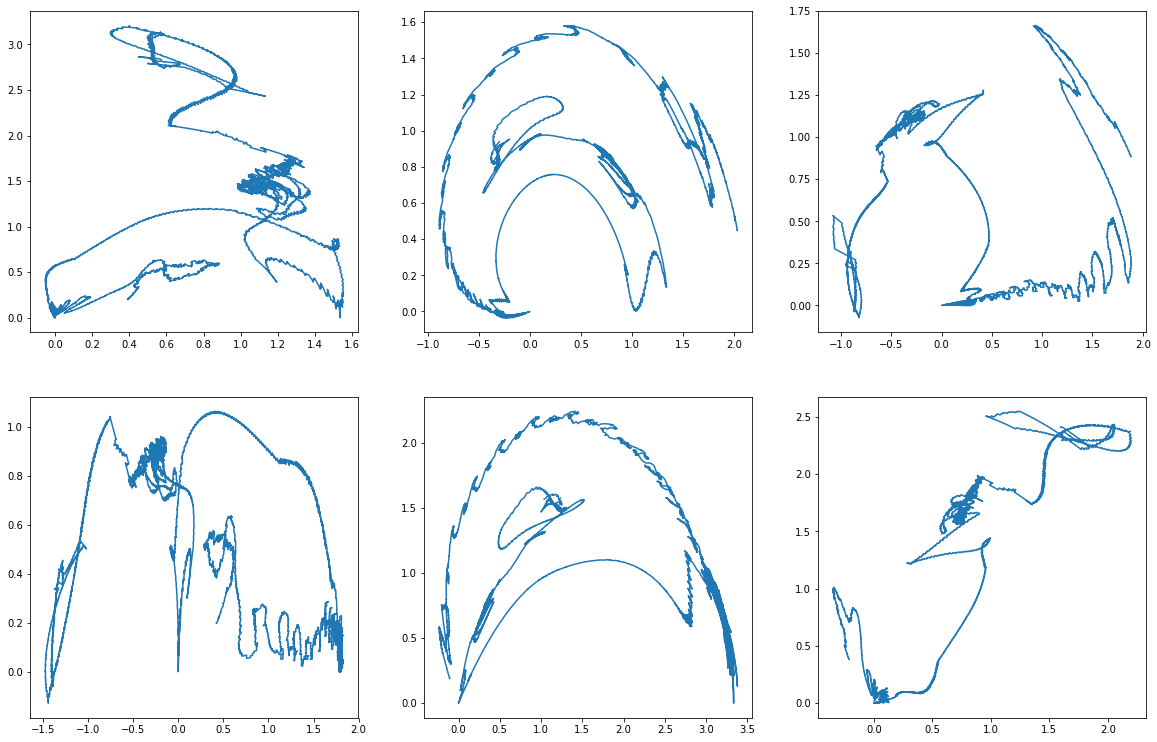

In [550]:
# plot
fig, ax = plt.subplots(2,3,figsize=(20, 13))
def pol(a,b):
    c = a * np.exp(1j*b)
    return np.real(c), np.imag(c)
ax[0, 0].plot(*pol(zx, std**.5))
ax[0, 1].plot(*pol(amp**.5, std))
ax[0, 2].plot(*pol(amp**.5, zx))
ax[1, 0].plot(*pol(std**.5, zx))
ax[1, 1].plot(*pol(std, amp**.5))
ax[1, 2].plot(*pol(zx, amp**.5))
pass

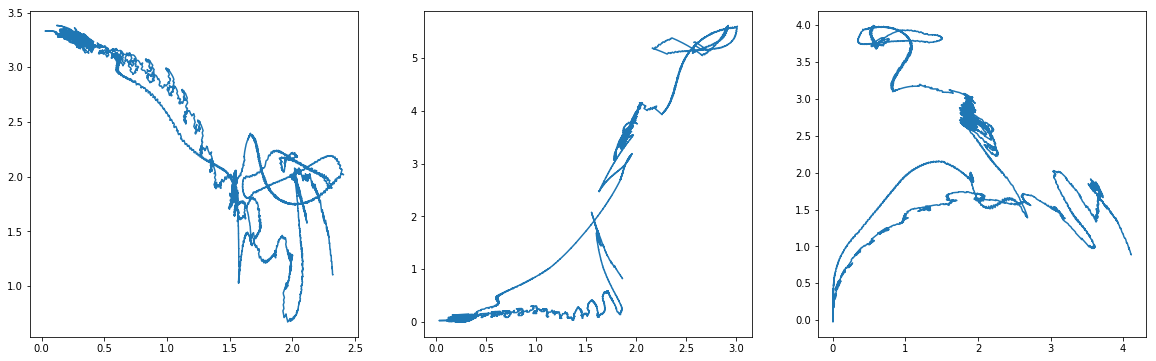

In [551]:
# plot
fig, ax = plt.subplots(1,3,figsize=(20, 6))
x0, y0 = zx, std
x1, y1 = pol(amp**.5, zx)
ax[0].plot(x0+x1, y0+y1)
x0, y0 = amp**.5, zx
x1, y1 = pol(zx, amp**.5)
ax[1].plot(x0+x1, y0+y1)
x0, y0 = amp**.5, zx
x1, y1 = pol(amp**.5, std)
ax[2].plot(x0+x1, y0+y1)
# ax[1].plot(amp**0.5, std)
# ax[2].plot(amp**0.5, zx)

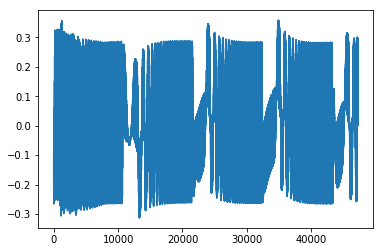

In [552]:
plt.plot(audio)

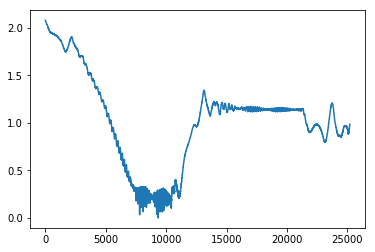

In [553]:
plt.plot(amp**0.5)

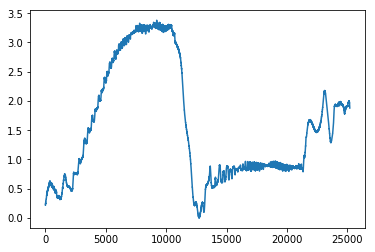

In [554]:
plt.plot(std)

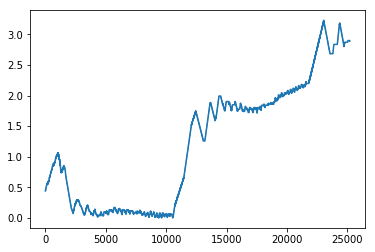

In [555]:
plt.plot(zx)

In [556]:
path = np.stack((zx, amp),0)#[:, :1000]
path.shape

(2, 25212)

In [557]:
def diff(arr, n=1, axis=-1, pad=None):
    if pad is None:
        pad = 0
    if not hasattr(pad, '__len__'):
        if axis<0:
            axis+=arr.ndim
        ps = [n if i==axis else k for i,k in enumerate(arr.shape)]
        pad = pad*np.ones(ps)
    return np.diff(np.concatenate((pad, arr), axis=axis), n=n, axis=axis)

In [558]:
def curv(arr, ws = 1000):
    a = diff(arr)
    a/=np.linalg.norm(a, axis=0)+1e-15
    a = diff(a)
    a = window(a, ws=ws).sum(-1)#/np.sqrt(ws)
    a = np.linalg.norm(a, axis=0)
    return a

def trim(arr, ws):
    """trim an array so its elements line up with window centers"""
    return arr[...,ws//2:-ws//2+1]

In [559]:
import pandas as pd
pd.Series(curv(path)).describe()

count    2.421300e+04
mean     1.045195e+00
std      9.188974e-01
min      2.220446e-16
25%      1.189493e-12
50%      1.388227e+00
75%      2.000000e+00
max      2.000000e+00
dtype: float64

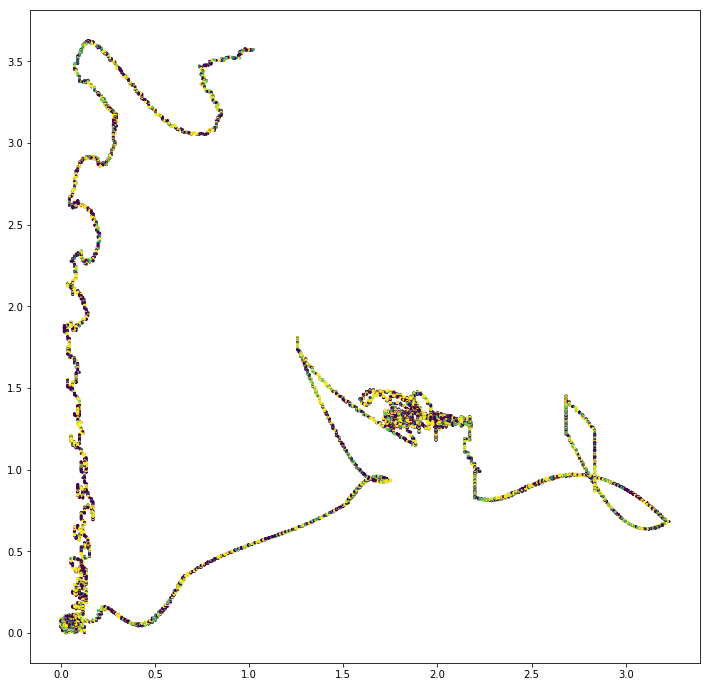

In [560]:
ws = 22050//10
fig, ax = plt.subplots(1,1,figsize=(12,12))
ax.scatter(*trim(path, ws), c=curv(path, ws), s=3)

In [603]:
p = trim(path, ws)
c = np.minimum(curv(path, ws), np.sqrt(2))#**0.5
smooth = np.zeros_like(p)
smooth[:,0] = p[:,0]
for i in range(1,len(c)):
    m = pow(.9999, c[i]*30)
    smooth[:,i] = smooth[:,i-1]*m + p[:,i]*(1-m)

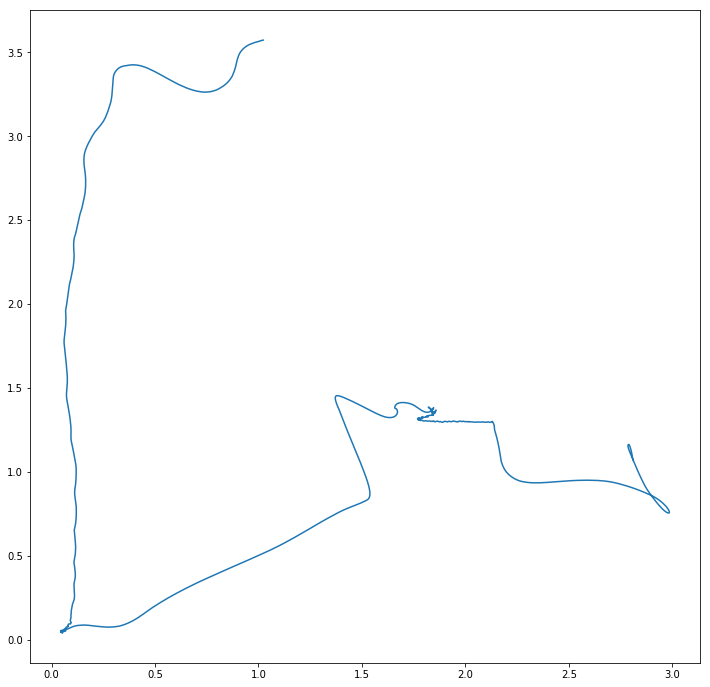

In [604]:
fig, ax = plt.subplots(1,1,figsize=(12,12))
# ax.scatter(*smooth, c=c, s=3)
plt.plot(*smooth)

In [585]:
# idea: fit each window tangent to a line, arc, or joint
# then integrate the stroke
# line:
# x = at + b
# y = ct + d
# min{a,b,c,d} Sum{i} |x[i]-ai-b|^2 + |y[i]-ci-d|^2 --> return dx/dt = a, dy/dt = c
# arc:
# |p - center| = r
# x = r cos(at + b) + c
# y = r sin(at + b) + d
# (x-b)^2 + (y-d)^2 = r^2

In [911]:
# idea: MFCC -> k-means
import librosa
mfcc = librosa.feature.mfcc(audio, samplerate, n_mfcc=26)

(26, 93)

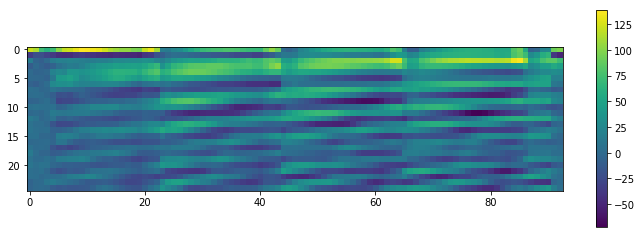

In [912]:
fig, ax = plt.subplots(1,1,figsize=(12, 4))
g = ax.imshow(mfcc[1:])
plt.colorbar(g)
mfcc.shape

In [913]:
centroids, _, _ = sklearn.cluster.k_means(mfcc[1:].T, 3)
centroids.shape

(3, 25)

In [914]:
centroids -= centroids.mean(1)[:, np.newaxis]
centroids /= centroids.std(1)[:, np.newaxis]

In [992]:
segments = []
steps = 1000
for i,centroid in enumerate(centroids):
    x0, y0, theta0, theta, length, branch, twist, fb0, fb1, fb2, fb3, fb4, fb5, fb6, fb7, fb8 = centroid[:16]
    branch = branch/(1+abs(branch))*.5+.5
    if i>0:
        x0, y0 = segments[-1][int(len(segments[-1])*branch), :2]
    s = [np.array([x0, y0, theta0])]
    for i in range(steps+int(length*steps)):
        z = s[-1].copy()
        z[2] += (
            theta + 
            fb0*z[0] + fb1*z[1] + 
            fb2*z[0]**2 + fb3*z[1]**2 + fb4*z[0]*z[1] + 
            fb5*z[0]**2*z[1] + fb6*z[0]*z[1]**2 + fb7*z[0]**3 + fb8*z[1]**3
        )/steps/2*twist
        z[:2] += np.array([np.cos(np.pi*z[2]), np.sin(np.pi*z[2])])/steps*8
        s.append(z)
    segments.append(np.array(s))

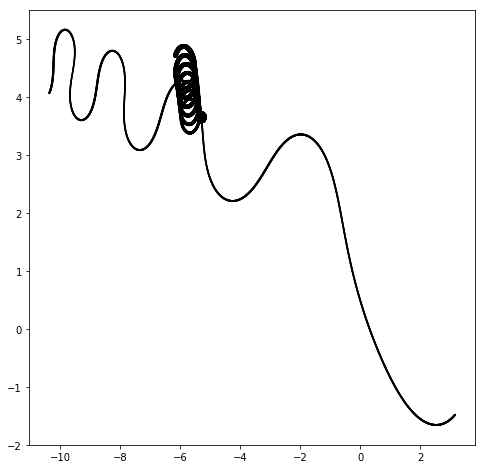

In [993]:
fig, ax = plt.subplots(1,1,figsize=(8,8))
for s in segments:
    plt.scatter(*s.T, color='black')

In [4]:
# sklearn.cluster.k_means?

In [1089]:
# for i in range(25):
#     mfcc = librosa.feature.mfcc(*read_audio(files[i]), n_mfcc=26)
#     n = int(mfcc.std(1).mean(0)/10)+1
#     print(n)

array([0, 1, 2, 4])

In [20]:
def project_ortho(theta0, phi0, theta1, phi1):
    v0 = pol2car(theta0, phi0)
    v1 = pol2car(theta1, phi1)
    v2 = v1-np.dot(v0, v1)*v0
    v2 /= np.linalg.norm(v2)
    return car2pol(*v2)
    
def pol2car(theta, phi):
    x,y = np.cos(theta), np.sin(theta)
    h,z = np.cos(phi), np.sin(phi)
    return np.array([x*h, y*h, z])

def car2pol(x, y, z):
    phi = np.arcsin(z)
    theta = np.arctan2(y, x)
    return theta, phi
    
def glyph(audio, samplerate, steps=1000, lp_coef=.99, twist_mult=2):
    mfcc = librosa.feature.mfcc(audio, samplerate, n_mfcc=26)
    n = int(mfcc.std(1).mean(0)/8)+1
    centroids, _, _ = sklearn.cluster.k_means(
        mfcc[1:].T, n,
        init=mfcc[1:,np.linspace(0, mfcc.shape[1]-1, n).astype(np.int64)].T, 
        n_init=1)
    centroids -= centroids.mean(0)
    centroids /= centroids.std(0)
    centroids = centroids[np.argsort(centroids[:, 0])] # deterministic order
    
    segments = []
    vertices, lines = [], []
    steps = 1000
    for i,centroid in enumerate(centroids):
        x0, y0, z0, theta0, phi0 = centroid[:5]
        theta0 *= np.pi/2
        phi0 *= np.pi/4
        fb = list(reversed(centroid[5:]))
        length = 1/2
        twist = twist_mult/4
        if i>0:
            branch = (x0/(1+abs(x0))*.5+.5) * len(segments)
            branch_on, branch_pt = int(branch), branch%1
            branch_idx = int(len(segments[branch_on])*branch_pt)
            length = (y0/(1+abs(y0))*.5+.5)**2
            twist = z0*abs(z0)**.5*twist_mult
            x0, y0, z0, theta_ortho, phi_ortho = segments[branch_on][branch_idx, :5]
            theta0, phi0 = project_ortho(theta_ortho, phi_ortho, theta0, phi0)
            lines.append([sum(len(s) for s in segments[:branch_on])+branch_idx+1])
        else:
            vertices.append(np.array([x0, y0, z0]))
            lines.append([1])
        twist/=2
        s = [np.array([x0, y0, z0, theta0, phi0])]
        
        z = s[0].copy()
        for i in range(steps//8+int(length*steps)):
            pt = s[-1].copy()
            z = z*lp_coef + pt*(1-lp_coef)
            pt[3] += (
                fb[18] + 
                fb[0]*z[0] + fb[2]*z[1] + fb[4]*z[2] + 
                fb[6]*z[0]*z[1] + fb[8]*z[1]*z[2] + fb[10]*z[2]*z[0] +
                fb[12]*z[0]**2 + fb[14]*z[1]**2 + fb[16]*z[2]**2
            )*np.pi/steps*twist
            pt[4] += (
                fb[19] + 
                fb[1]*z[0] + fb[3]*z[1] + fb[5]*z[2] + 
                fb[7]*z[0]*z[1] + fb[9]*z[1]*z[2] + fb[11]*z[2]*z[0] +
                fb[13]*z[0]**2 + fb[15]*z[1]**2 + fb[17]*z[2]**2
            )*np.pi/steps*twist
            pt[:3] += pol2car(pt[3], pt[4])/steps
            
            s.append(pt)
            vertices.append(pt[:3])
            lines[-1].append(len(vertices))

            
        segments.append(np.array(s))
        
    vertices = np.array(vertices)
    vertices -= vertices.mean(0)
        
    return vertices, lines

In [18]:
def plot_vertices(ax, v):
    idxs = np.argsort(v[:, 2])
    ax.scatter(v[idxs, 0], v[idxs, 1], c=-v[idxs, 2], s=8, cmap='YlOrRd')

def plot_glyph(vertices):
    fig, ax = plt.subplots(1,3,figsize=(18,6))
    for a in ax:
        a.axis('off')
    fig.set_facecolor('black')
    plot_vertices(ax[0], vertices)
    plot_vertices(ax[1], vertices[:, [1,2,0]])
    plot_vertices(ax[2], vertices[:, [2,0,1]])
    plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)

In [7]:
def read_audio(fname):
    audio, samplerate = sf.read(fname)
    if audio.ndim>1:
        audio = audio.mean(1)
    return audio, samplerate

In [8]:
def write_obj(fname, vertices, lines):
    with open(fname, 'w') as file:
        for v in vertices:
            file.write('v '+' '.join(str(el) for el in v)+'\n')
        for l in lines:
            file.write('l '+' '.join(str(int(el)) for el in l)+'\n')

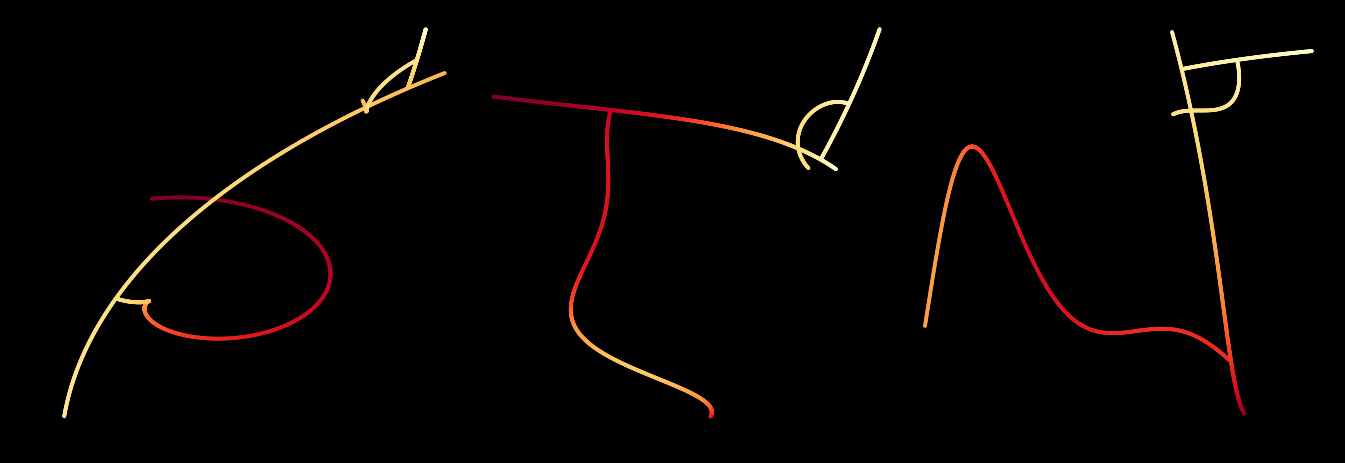

In [26]:
audio, sr = read_audio(files[0])
plot_glyph(glyph(audio, sr, twist_mult=2)[0])
display_audio(audio, sr)

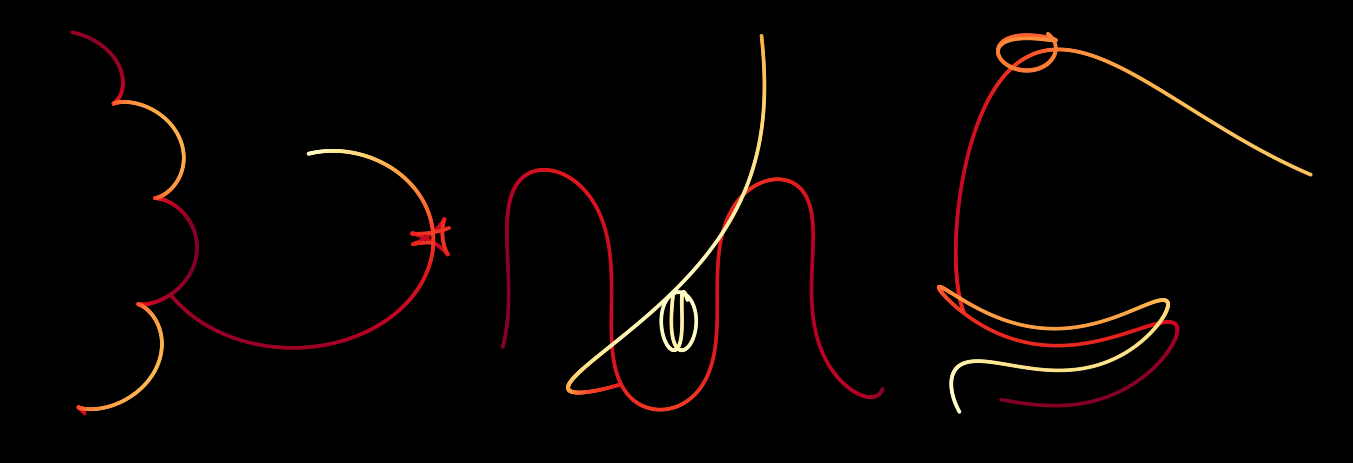

In [27]:
audio, sr = read_audio(files[1])
plot_glyph(glyph(audio, sr, twist_mult=8)[0])
display_audio(audio, sr)

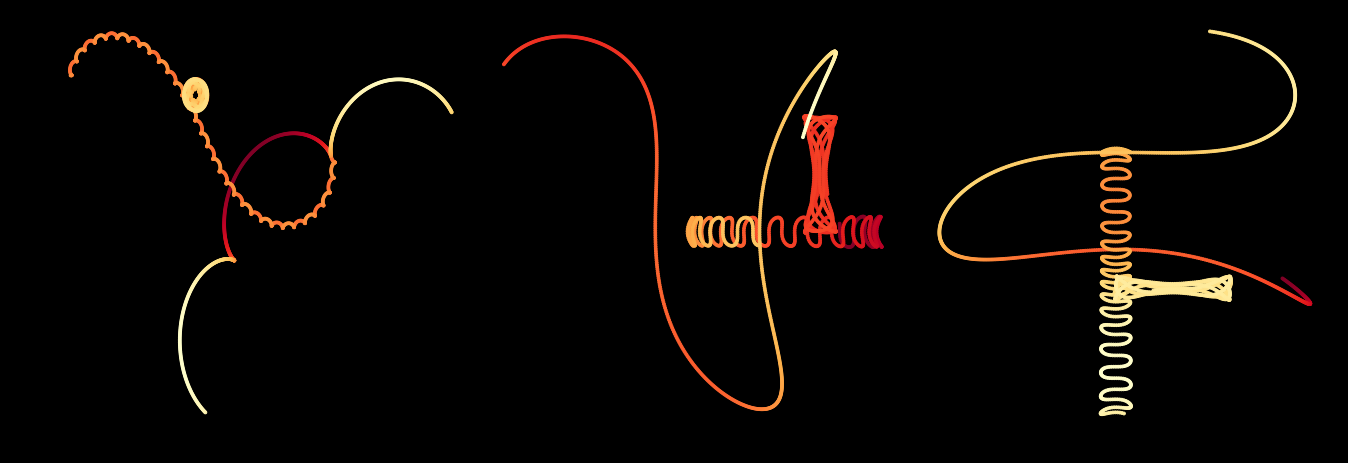

In [29]:
audio, sr = read_audio(files[2])
plot_glyph(glyph(audio, sr, twist_mult=16)[0])
display_audio(audio, sr)

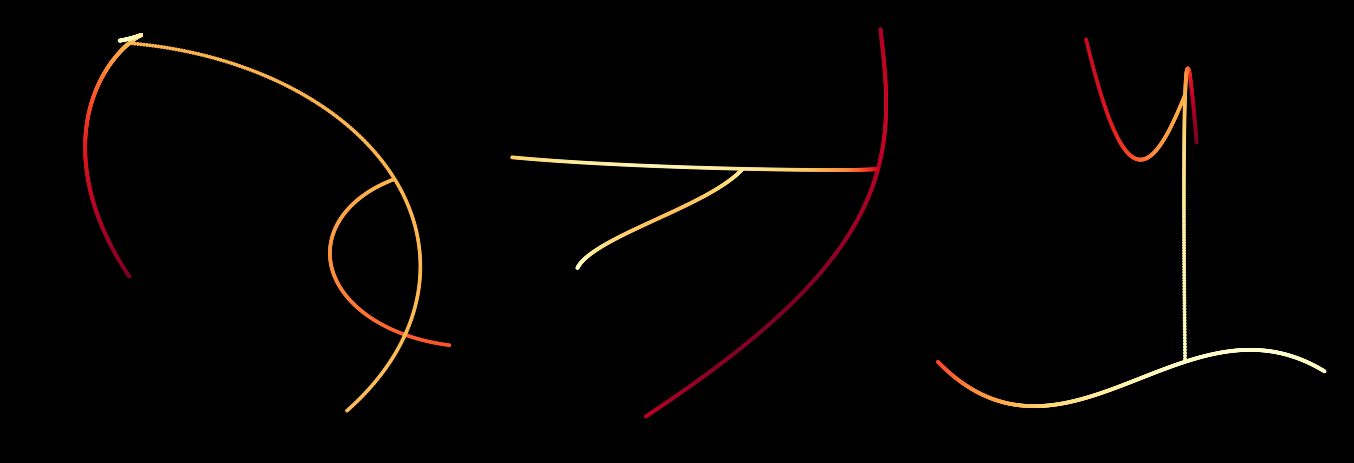

In [1376]:
audio, sr = read_audio(files[3])
plot_glyph(glyph(audio, sr)[0])
display_audio(audio, sr)

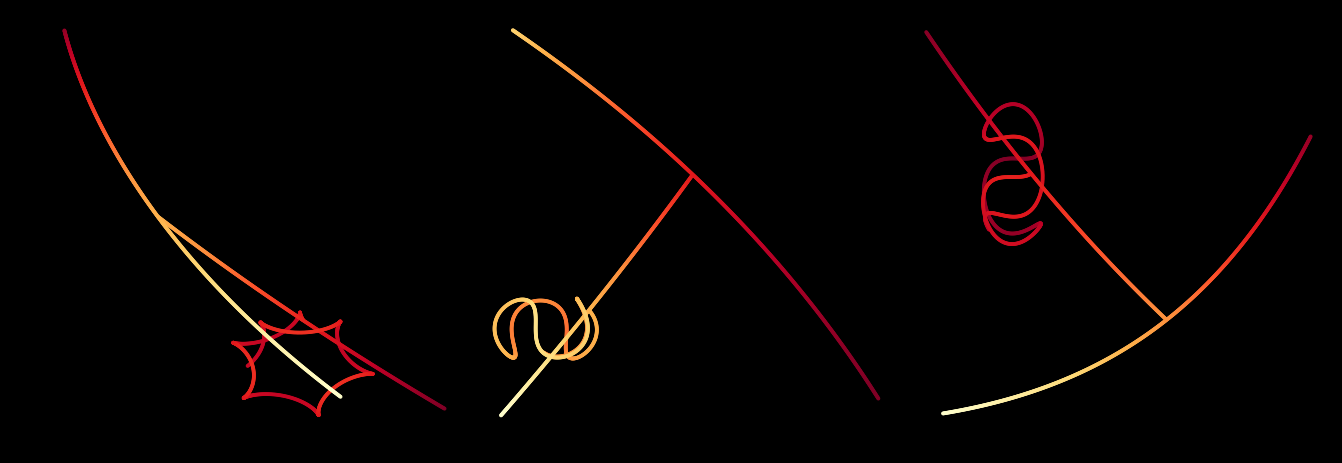

In [1377]:
audio, sr = read_audio(files[4])
plot_glyph(glyph(audio, sr)[0])
display_audio(audio, sr)

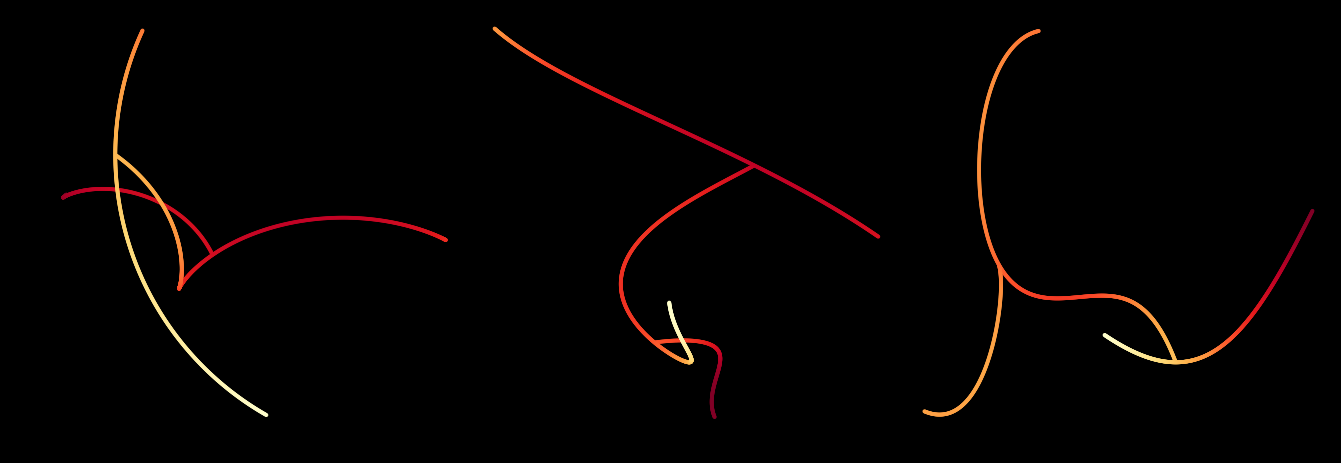

In [1378]:
audio, sr = read_audio(files[5])
plot_glyph(glyph(audio, sr)[0])
display_audio(audio, sr)

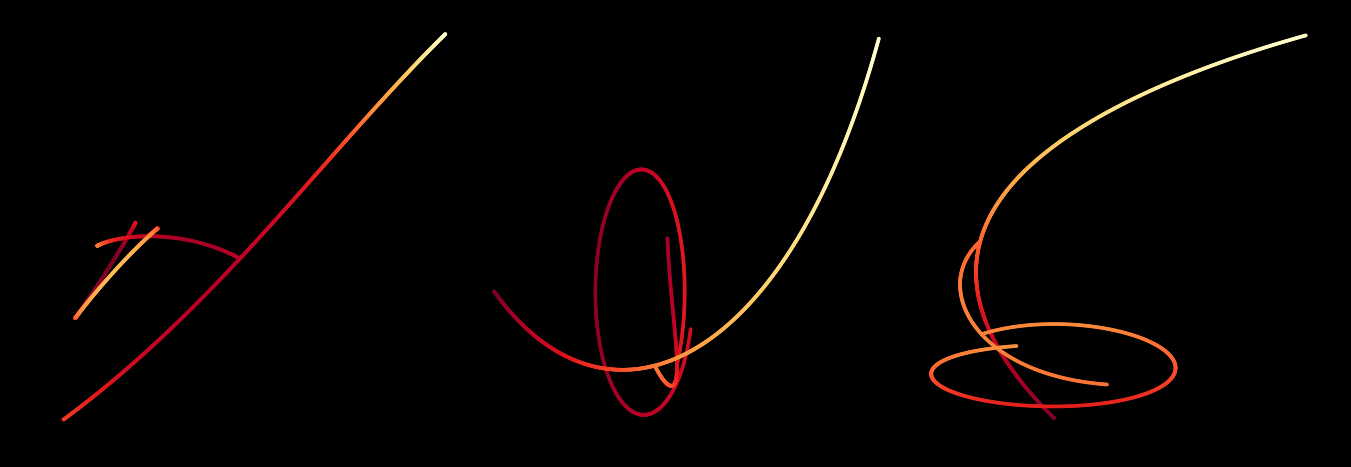

In [1379]:
audio, sr = read_audio(files[6])
plot_glyph(glyph(audio, sr)[0])
display_audio(audio, sr)

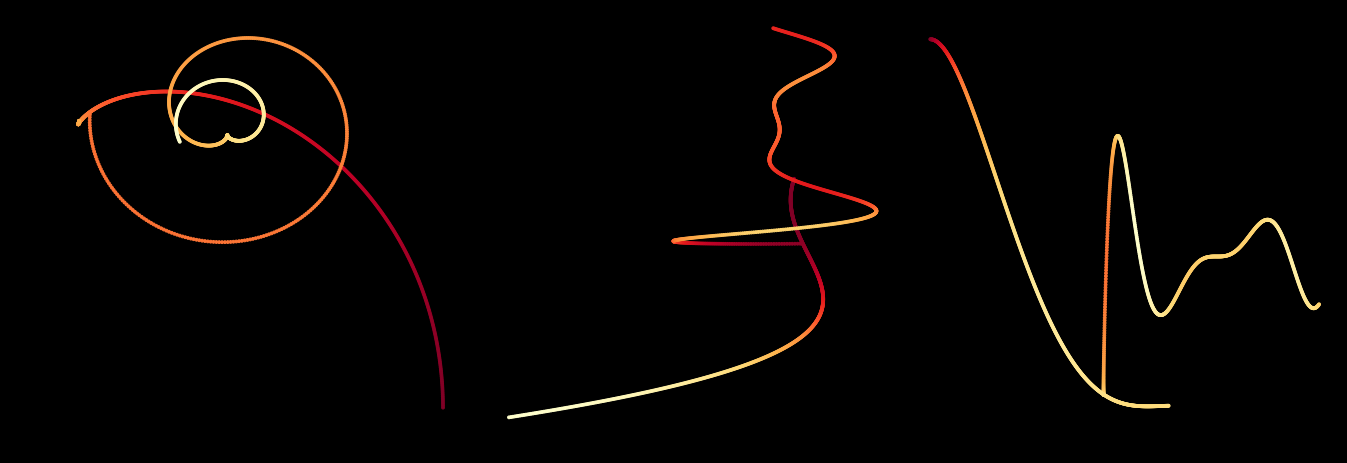

In [14]:
audio, sr = read_audio(files[7])
plot_glyph(glyph(audio, sr)[0])
display_audio(audio, sr)

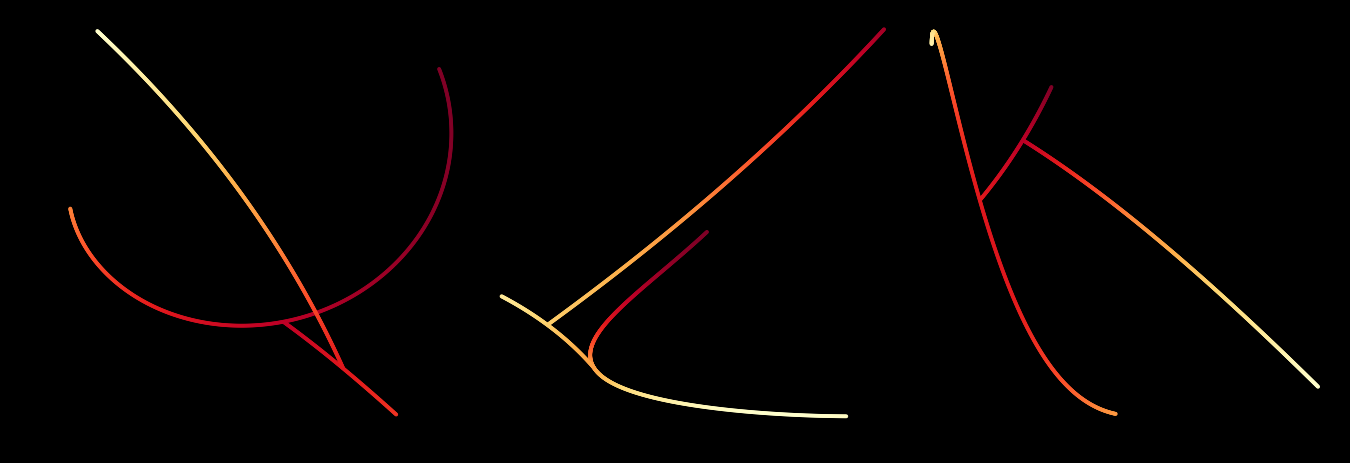

In [16]:
audio, sr = read_audio(files[8])
plot_glyph(glyph(audio, sr)[0])
display_audio(audio, sr)